In [1]:
%matplotlib inline  # 用于在Notebook中内嵌显示Matplotlib图像
import random
import torch
from d2l import torch as d2l

w：表示真实的权重向量（例如，[2, -3.4]） \
b：表示真实的偏置（例如，4.2）。 \
num_examples：表示生成的数据样本的数量（例如，1000条）。 \
 \
torch.normal(mean, std, size)：是PyTorch中的函数，用于生成符合正态分布的数据。它会生成一个矩阵，矩阵中的每个元素来自于一个均值为mean，标准差为std的正态分布。 \
mean=0：每个元素的均值为0。 \
std=1：每个元素的标准差为1。 \
size=(num_examples, len(w))：生成一个大小为 (num_examples, len(w)) 的矩阵。 \
 \
 torch.matmul(X, w)：矩阵乘法操作，用来计算输入特征与权重的线性组合，其中： \
X 是一个矩阵，代表特征。 \
w 是一个列向量，代表权重。 \
结果是一个 num_examples x 1 的列向量，表示每个样本对应的预测值。 \
 \
y.reshape((-1, 1))：将标签 y 调整为列向量的形状，其中 -1 表示行数自动推导，1 表示将 y 调整为 num_examples x 1 的形状，以确保其为列向量。


In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.8292,  1.0824]) 
label: tensor([-1.1324])


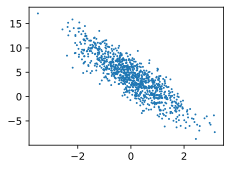

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # min(i + batch_size, num_examples)确保最后一批次的索引不超过样本总数（防止越界）
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10
# 设置小批量大小并打印一批数据
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8158,  1.0805],
        [ 2.0173, -0.9718],
        [ 1.1055, -1.3310],
        [ 0.3766, -0.9212],
        [-0.0224, -0.0650],
        [ 0.0252,  0.4221],
        [-0.8907, -0.9165],
        [-1.1069, -0.2374],
        [-0.5399,  0.7849],
        [-1.0213, -1.1064]]) 
 tensor([[ 2.1662],
        [11.5310],
        [10.9259],
        [ 8.0829],
        [ 4.3865],
        [ 2.8035],
        [ 5.5454],
        [ 2.7880],
        [ 0.4384],
        [ 5.9302]])


In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

预测值y_hat \
真实标签y

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041143
epoch 2, loss 0.000157
epoch 3, loss 0.000049


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0010], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)
